In [1]:
%%capture
%load_ext autoreload
%autoreload 2
from setup_nb_env import *

from epsampling.utils import load_csv
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
from epsampling.utils import drop_sers_with_nans
from epsampling.utils import date_str_to_int

DATA_DIR = '/work/users/k/4/k4thryn/Repos/EpSampling/data/'
DT = datetime.today().strftime('%Y%m%d-%H%M%S')

In [2]:
### LOAD CSV
timestamp = '20241004-192756'
fpath = os.path.join(DATA_DIR,'processed', 'scratch', f'formatted_state_inc_deaths_{timestamp}.csv')
df_deaths = pd.read_csv(fpath)
df_deaths

,State_fips,Date,True_inc_state_deaths,Proj_inc_deaths,State_pop
0,1,20200613,4.0,69.729674,4997675
1,1,20200620,16.0,83.302156,4997675
2,1,20200627,12.0,68.179357,4997675
3,1,20200704,1.0,76.238975,4997675
4,1,20200711,10.0,88.362530,4997675
...,...,...,...,...,...
4971,56,20220409,0.0,8.000000,576641
4972,56,20220416,0.0,5.000000,576641
4973,56,20220423,0.0,4.000000,576641
4974,56,20220430,0.0,4.000000,576641


In [3]:
# # # # # # # # # # # # # # # # # # # # # # # # #
# NAIVE PREDICTION PERFORMANCE FOR EACH STATEEE
# # # # # # # # # # # # # # # # # # # # # # # # #

from epsampling.utils import get_performance
import pprint

county_res_dict = {}

fipss = df_deaths.State_fips.unique()

for fips in tqdm(df_deaths.State_fips.unique(), total = len(fipss)):
    
    df_fips = df_deaths[df_deaths.State_fips==fips]
#     display(df_fips)
    
    y_naive = df_fips['Proj_inc_deaths'].values
    y_test = df_fips['True_inc_state_deaths'].values

    model_names = ['Proj_inc_deaths'] #,'Deaths_true']
    model_preds = [y_naive]
    
    metrics_dict = get_performance(model_names, model_preds, y_test, y_naive)
    county_res_dict[fips] = list(metrics_dict.values())[0]
    
df_res = pd.DataFrame([[county,metric,value] 
                       for county,d in county_res_dict.items() 
                       for metric,value in d.items()], 
                       columns = ['State_fips','metric','value'])

df = df_res.pivot(index='State_fips',columns='metric',values='value')
# df.drop('relMAE',axis=1,inplace=True)

df.reset_index(inplace=True)
df.columns.name = None
df.index.name = None

dff = df.merge(df_deaths[['State_fips','State_pop']], on='State_fips')
dff.drop_duplicates(inplace=True)
df = dff[['State_fips', 'State_pop', 'MAE', 'relMAE', 'MSE', 'RMSE', 'r2']]

## compute normalize MAE (divide it by county pop)
df['normMAE'] = df.apply(lambda x: x.MAE / x.State_pop, axis=1)

# ## drop giant county
# max_pop = df.Pop.max()
# df = df[df.Pop < max_pop]

# display(df)

100%|██████████| 50/50 [00:00<00:00, 567.86it/s]


In [4]:
df

,State_fips,State_pop,MAE,relMAE,MSE,RMSE,r2,normMAE
0,1,4997675,148.620921,1.00,42292.087226,205.650401,-24.843057,0.000030
100,2,735951,9.421117,0.99,177.311346,13.315831,-40.528796,0.000013
200,4,7079203,233.293943,1.00,93799.201395,306.266553,-50.514001,0.000033
299,5,3006309,94.628110,1.00,13518.576236,116.269412,-99.243712,0.000031
399,6,39455353,745.963244,1.00,961948.155464,980.789557,-43.250577,0.000019
497,8,5723176,95.767326,1.00,16748.877623,129.417455,-99.224130,0.000017
595,9,3605330,66.102428,1.00,9427.316574,97.094369,-80.898613,0.000018
695,10,981892,15.049831,0.99,362.358784,19.035724,-2.287372,0.000015
795,12,21339762,628.238922,1.00,606792.186387,778.968668,-184.135544,0.000029
895,13,10625615,296.758105,1.00,121271.113133,348.240022,-54.815665,0.000028


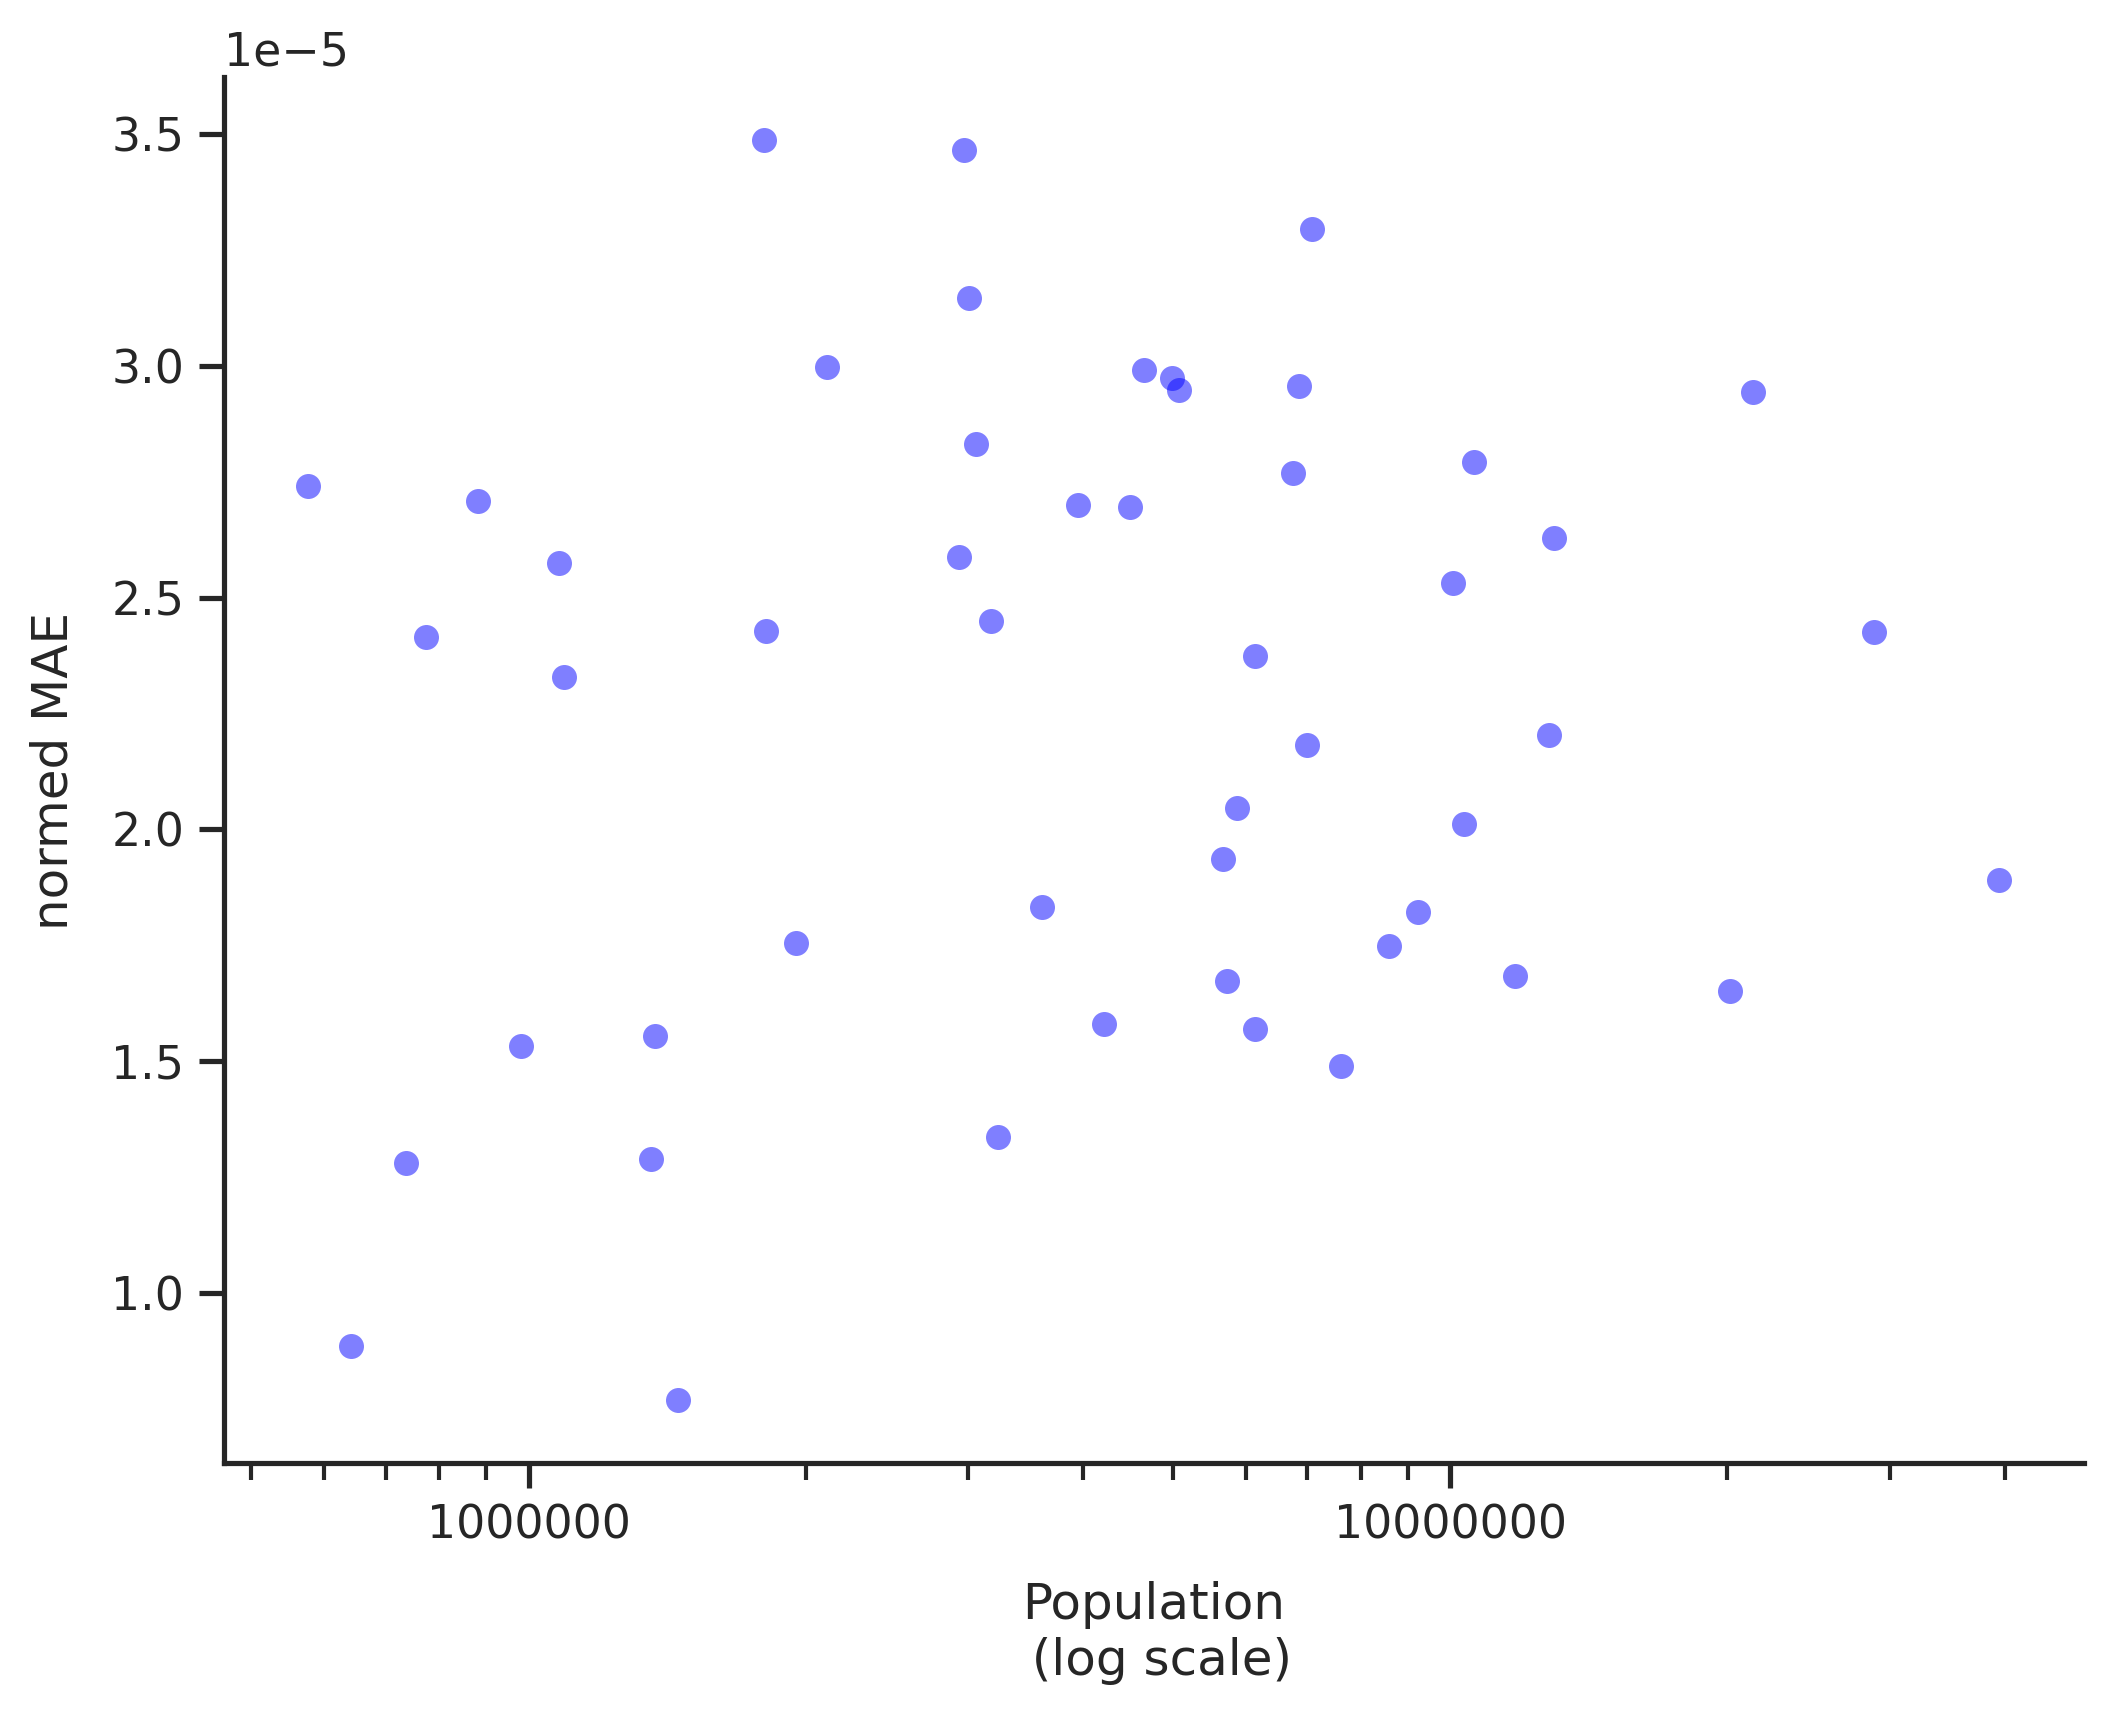

In [5]:
# # # # # # # # # # # # # # # # # # # # # # # # #
# PLOT normMAE vs. STATE POPULATION
# # # # # # # # # # # # # # # # # # # # # # # # #

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1, style='ticks') 

from matplotlib import ticker as mtick

metric = 'normMAE'

FIGSIZE = (8,6)
ALPHA = 0.5
SIZES = 2
LINEWIDTH = 0
DPI = 300
LABELPAD = 8
  
plt.figure(figsize=FIGSIZE)
ax = sns.scatterplot(data=df, x="State_pop", y=metric, alpha=ALPHA, 
                     sizes=SIZES, linewidth=LINEWIDTH, c='blue')

plt.xlabel('Population\n (log scale)',labelpad=LABELPAD)
# plt.ylabel('MAE (population normed)')
# plt.ylabel(' Mean absolute error\n(normed by population)', labelpad=LABELPAD)
plt.ylabel('normed MAE', labelpad=LABELPAD)

# plt.xt

plt.xscale('log')
xticks = mtick.FormatStrFormatter('%d')
plt.gca().xaxis.set_major_formatter(xticks)

ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

sns.despine()
plt.gcf().set_dpi(DPI)
# plt.show()

### <font color=blue> Combine with county-level results.

In [6]:
## LOAD CSV!
timestamp = '20241004-193554'
fpath = os.path.join(DATA_DIR,'processed','scratch', f'county_metrics_for_mae_fig_{timestamp}.csv')
df_county = pd.read_csv(fpath)
df_county['Is_state'] = False

dff = df.rename({'State_pop':'Pop','State_fips':'Fips'},axis=1)
dff['Is_state'] = True

## Combine !!
df_tot = pd.concat([df_county, dff])
df_tot.drop('Ratio',axis=1,inplace=True)
# df_tot

,Fips,Pop,MAE,relMAE,MSE,RMSE,r2,normMAE,Is_state
0,1001,58239,1.442469,1.0,4.288161,2.070788,0.300375,0.000025,False
1,1003,227131,5.212893,1.0,65.629623,8.101211,0.171386,0.000023,False
2,1005,25259,0.897593,1.0,4.181049,2.044761,0.047110,0.000036,False
3,1007,22412,0.966661,1.0,5.255706,2.292533,0.023673,0.000043,False
4,1009,58884,1.489784,1.0,5.462142,2.337123,0.373556,0.000025,False
...,...,...,...,...,...,...,...,...,...
4480,51,8582479,150.070137,1.0,34527.862131,185.816743,-48.238604,0.000017,True
4580,53,7617364,113.483874,1.0,18708.693380,136.779726,-1308.073033,0.000015,True
4676,54,1801049,62.801785,1.0,6626.385463,81.402613,-140.966798,0.000035,True
4776,55,5871661,120.159309,1.0,23697.735646,153.940689,-47.953323,0.000020,True


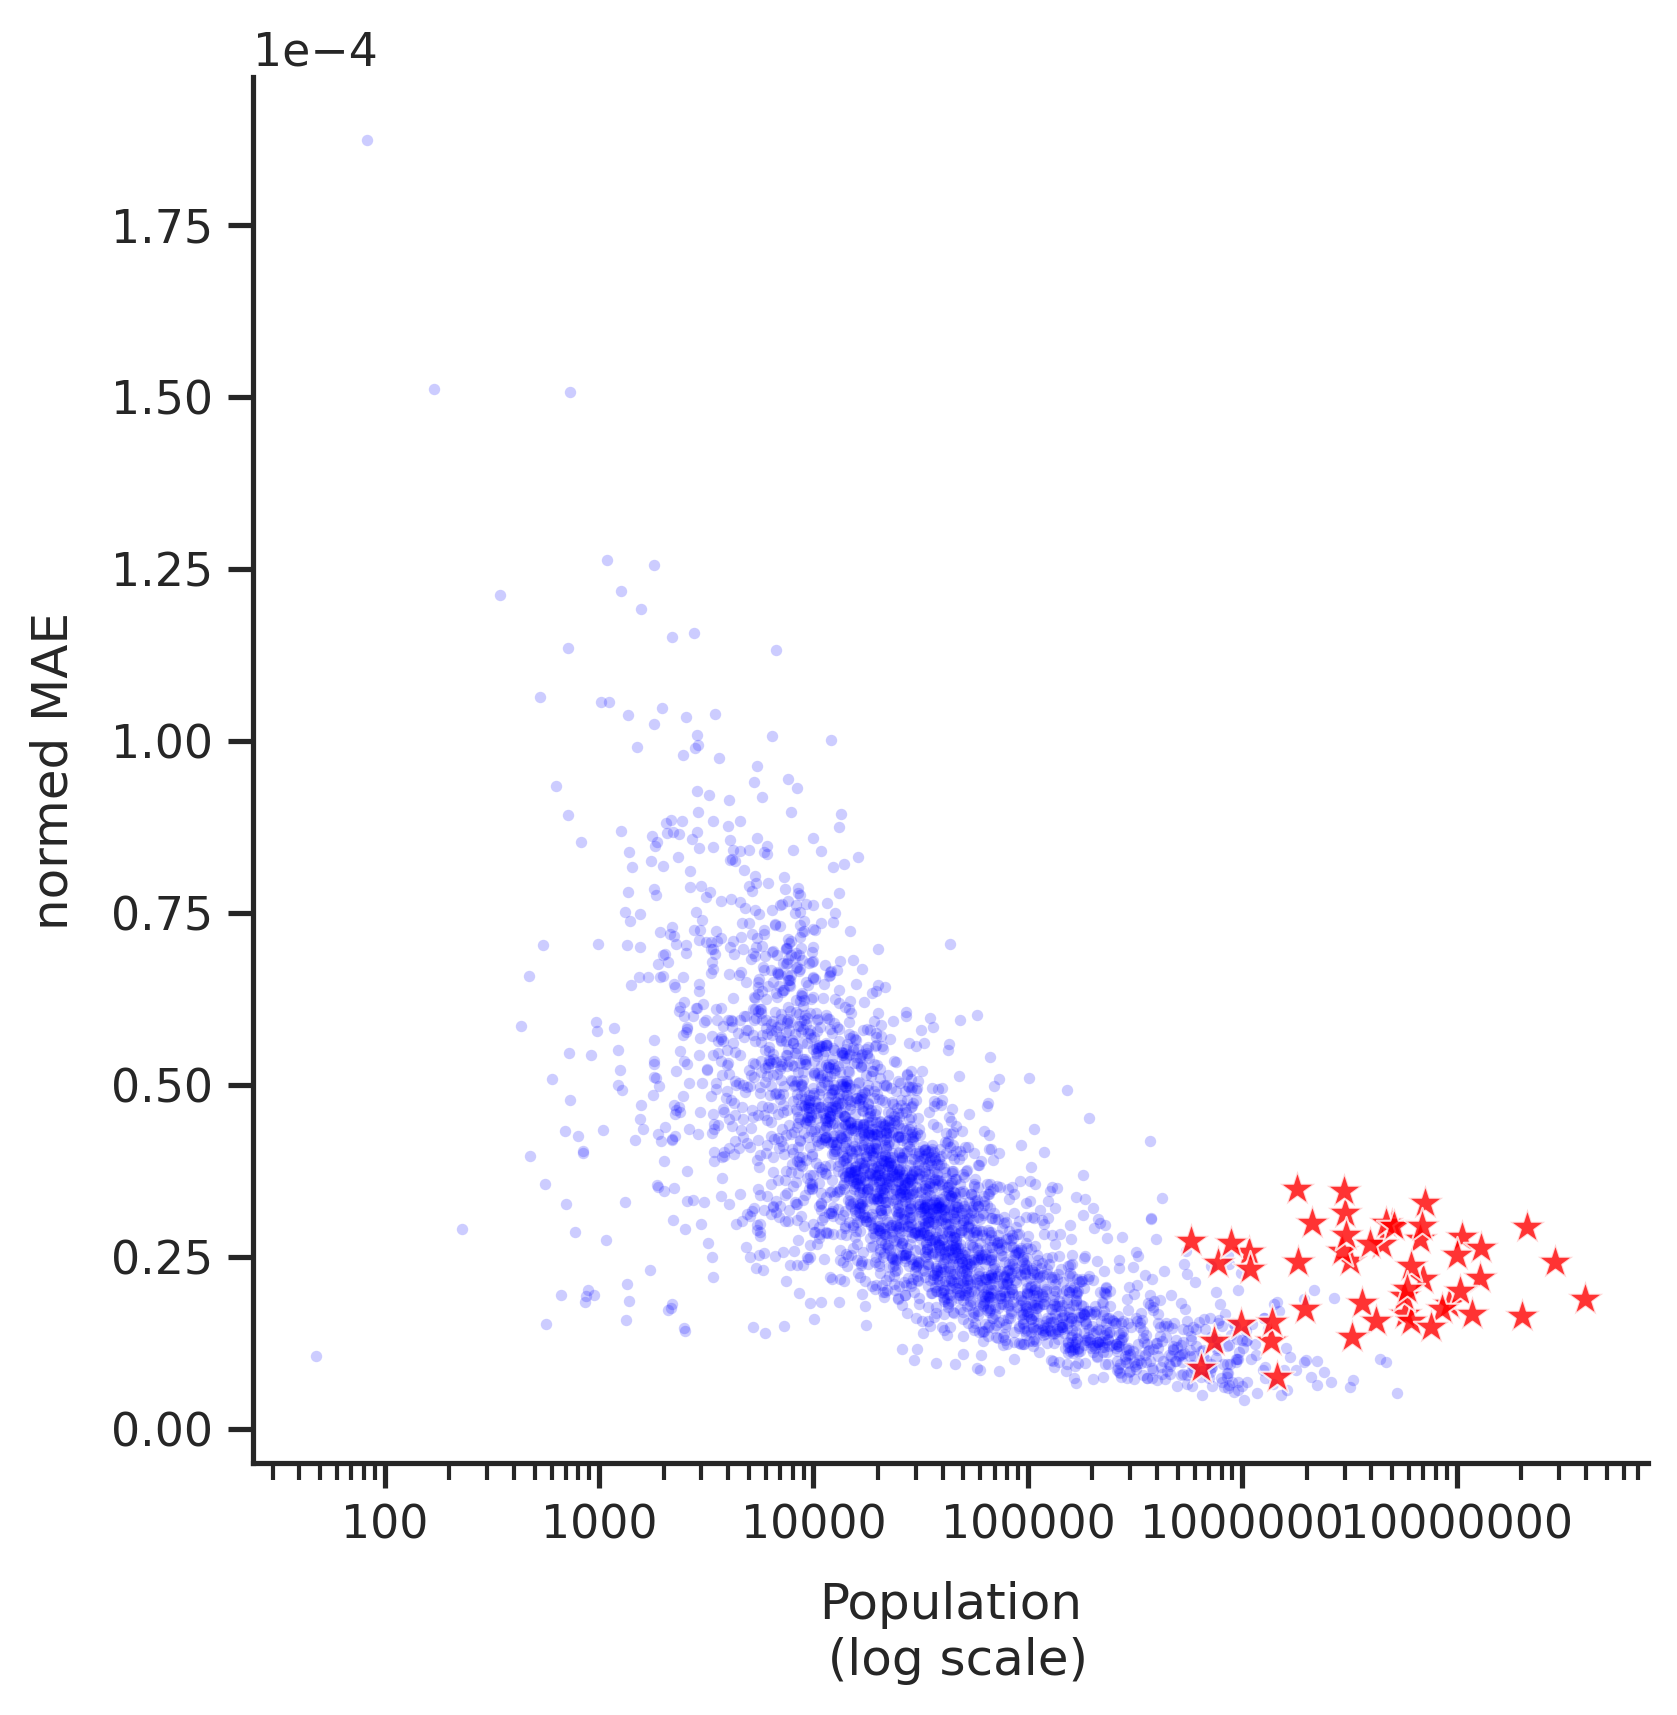

In [43]:
# # # # # # # # # # # # # # # # # # # # # # # # #
# PLOT normMAE vs. POPULATION
# # # # # # # # # # # # # # # # # # # # # # # # #

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1, style='ticks') 

from matplotlib import ticker as mtick

metric = 'normMAE'

# FIGSIZE = (8,6)
FIGSIZE = (6,6)

ALPHA = 0.2
SIZE = 30
LINEWIDTH = 0
DPI = 300
LABELPAD = 8
  
plt.figure(figsize=FIGSIZE)
# ax = sns.scatterplot(data=df_tot, x="Pop", y=metric, alpha=ALPHA, 
#                      sizes=SIZES, linewidth=LINEWIDTH,hue='Is_state',hue_order=[True,False])

ax = sns.scatterplot(data=df_tot[df_tot.Is_state==False], x="Pop", y=metric, alpha=ALPHA, 
                     s=SIZE, linewidth=LINEWIDTH,
                     c='blue',
                     marker='.')

sns.scatterplot(data=df_tot[df_tot.Is_state==True], x="Pop", y=metric, alpha=0.8, 
                     s=80, linewidth=0.5, edgecolor='w', c='red',ax=ax, marker='*',)

plt.xlabel('Population\n (log scale)',labelpad=LABELPAD)
# plt.ylabel('MAE (population normed)')
# plt.ylabel(' Mean absolute error\n(normed by population)', labelpad=LABELPAD)
plt.ylabel('normed MAE', labelpad=LABELPAD)

# plt.xt

plt.xscale('log')
xticks = mtick.FormatStrFormatter('%d')
plt.gca().xaxis.set_major_formatter(xticks)

ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

sns.despine()
plt.gcf().set_dpi(DPI)
plt.show()

In [ ]:
# timestamp = '20241001-223952'
# fpath = os.path.join(DATA_DIR,'processed', f'formatted_COVIDhub-ensemble_{timestamp}.csv')
# df_deaths = pd.read_csv(fpath)
# df_deaths